# Lab 2 Kalman Filter - Car Tracking

### SIC7001 Signal Enhancement Methods
### Mochamad Ardiansyah NUGRAHA

In [141]:
import numpy as np
from scipy.linalg import expm
from scipy.integrate import trapz
import matplotlib.pyplot as plt

In [142]:
## CONTINUOUS TIME MODEL ##

# process noise wt, covariance matrix
q = 1
Qc = np.array([[q, 0], [0, q]])

# measurement noise nt, covariance matrix
s = 2
R = np.array([[s**2, 0], [0, s**2]])

# state equation: xt = [px, py, pdot_x, pdot_y]^T
def state_cont(px, py, pdot_x, pdot_y):
    return np.array([px, py, pdot_x, pdot_y])

# state-space: xdot = Ac.xt + B.wt
Ac = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0]])
B = np.array([[0, 0], [0, 0], [1, 0], [0, 1]])
def state_space_cont(Ac, x, B, w):
    return Ac @ x + B @ w

# measurement: yt = C.xt + nt
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
def measurement_cont(C, x, n):
    return C @ x + n

## Problem 1: Discrete Time Model

### Problem 1.1: Calculate A, C

In [143]:
# sampling time
Ts = 0.1

# compute transition matrix: A
def A_disc(Ac, Ts):
    A = expm(Ac * Ts)
    return A

A = A_disc(Ac, Ts)
print("A:", A)
print("C:", C)

A: [[1.  0.  0.1 0. ]
 [0.  1.  0.  0.1]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]]
C: [[1 0 0 0]
 [0 1 0 0]]


### Problem 1.2: Calculate Cov(q)

In [144]:
Sigma_w = Qc

def integrand(A, Ts, t, B, Sigma_w):
    return expm(A * (Ts - t)) @ B @ Sigma_w @ B.T @ expm(A * (Ts - t)).T

def integrate_matrix(A, Ts, B, Sigma_w, num_steps=1000):
    t_values = np.linspace(0, Ts, num_steps)
    integrand_values = np.array([integrand(A, Ts, t, B, Sigma_w) for t in t_values])
    integrated_matrix = trapz(integrand_values, x=t_values, axis=0)
    return integrated_matrix

# calculate Cov(q) = Q
Q = integrate_matrix(A, Ts, B, Sigma_w)
print("Cov(q) = Q =", Q)

Cov(q) = Q = [[3.87565647e-06 0.00000000e+00 5.71944876e-04 0.00000000e+00]
 [0.00000000e+00 3.87565647e-06 0.00000000e+00 5.71944876e-04]
 [5.71944876e-04 0.00000000e+00 1.10701379e-01 0.00000000e+00]
 [0.00000000e+00 5.71944876e-04 0.00000000e+00 1.10701379e-01]]


## Problem 2: Simulated Data

### Problem 2.1

In [145]:
# new process noise w (R^2)
mean_w = np.zeros(2)
Cov_w = np.identity(2)

# white Gaussian noise v, covariance matrix
mean_v = np.zeros(2)
Cov_v = np.array([[2, -1], [-1, 2]])

w = np.random.multivariate_normal(mean_w, Cov_w)
L = np.linalg.cholesky(Cov_v)

v = np.dot(L, w)

print("v:", v)

v: [-0.37560677  1.82698272]


### Problem 2.2

In [146]:
# discrete model
def discrete_model(A, x_prev, q_prev, C, r):
    x = A @ x_prev + q_prev
    y = C @ x + r
    return x, y

# Gaussian process x[0], mean m0, covariance matrix P0
m0 = np.array([0, 0, 1, -1])
P0 = np.identity(4)

# number of steps
N = 100

mean_q = np.zeros(4)
mean_r = np.zeros(2)

q = np.zeros((N, 4))
r = np.zeros((N, 2))
x = np.zeros((N, 4)) 
y = np.zeros((N, 2))
# print(x.shape)
# print(y.shape)

# calculate initial state and measurement
q[0] = np.random.multivariate_normal(mean_q, Q)
r[0] = np.random.multivariate_normal(mean_r, R)
x[0] = np.random.multivariate_normal(m0, P0)
y[0] = C @ x[0] + r[0]

for k in range(N - 1):
    q[k + 1] = np.random.multivariate_normal(mean_q, Q)
    r[k + 1] = np.random.multivariate_normal(mean_r, R)
    x[k + 1], y[k + 1] = discrete_model(A, x[k], q[k], C, r[k + 1])
    # print(f"x[{k}]: ", x[k])
    # print(f"y[{k}]: ", y[k])

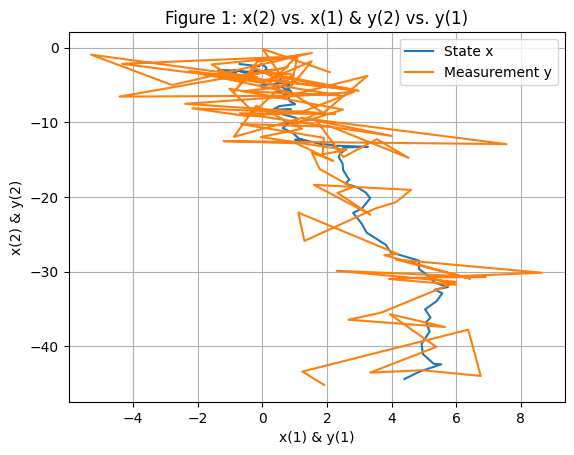

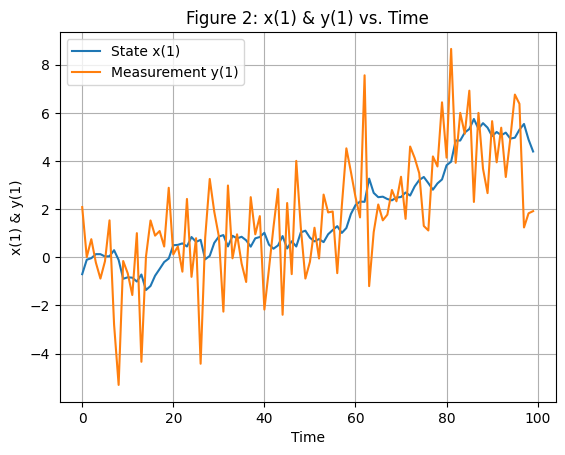

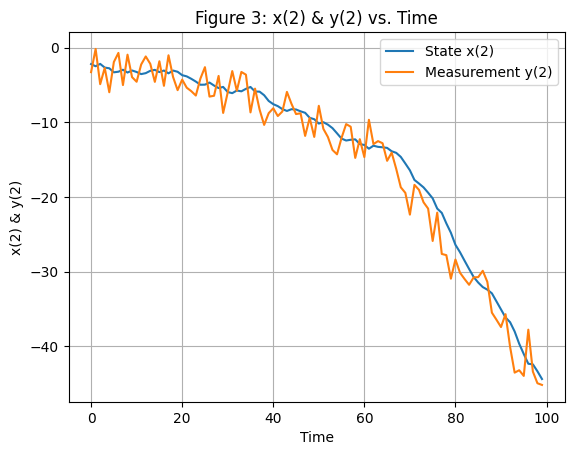

In [284]:
# plot
plt.plot(x[:, 0], x[:, 1], label="State x")
plt.plot(y[:, 0], y[:, 1], label="Measurement y")
plt.xlabel("x(1) & y(1)")
plt.ylabel("x(2) & y(2)")
plt.title("Figure 1: x(2) vs. x(1) & y(2) vs. y(1)")
plt.grid(True)
plt.legend()
plt.show()

# time
t = np.arange(N)

for k in range(2): 
# plt.figure(figsize=(10, 3))
    plt.plot(t, x[:, k], label=f"State x({k + 1})")
    plt.plot(t, y[:, k], label=f"Measurement y({k + 1})")
    plt.xlabel("Time")
    plt.ylabel(f"x({k + 1}) & y({k + 1})")
    plt.title(f"Figure {k + 2}: x({k + 1}) & y({k + 1}) vs. Time")
    plt.grid(True)
    plt.legend()
    plt.show()

### Problem 2.3: Speed

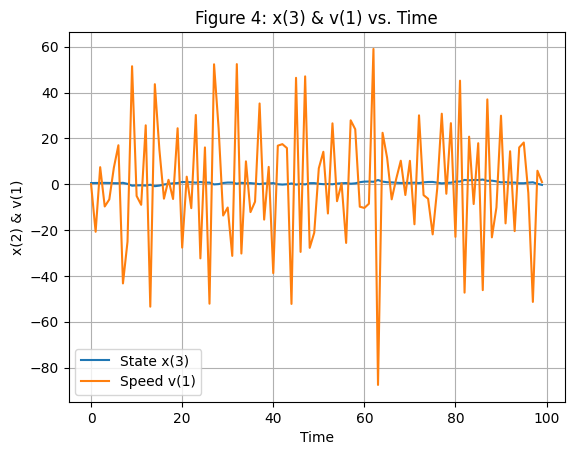

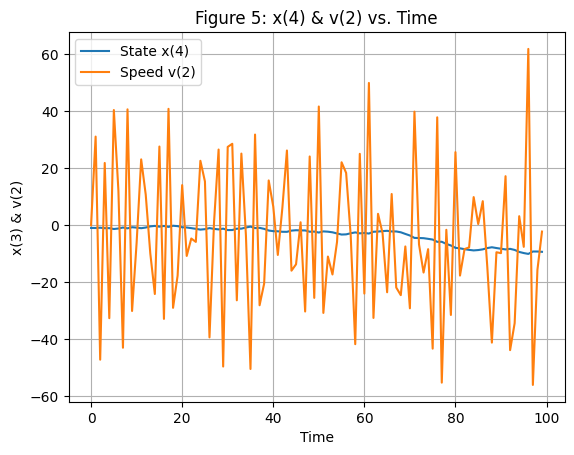

In [285]:
# speed
def speed(y, y_prev, dt):
    return (y - y_prev) / dt

v = np.zeros((N, 2))

for k in range(N - 1):
    v[k + 1] = speed(y[k + 1], y[k], Ts)

for k in range(2): 
# plt.figure(figsize=(10, 3))
    plt.plot(t, x[:, k + 2], label=f"State x({k + 3})")
    plt.plot(t, v[:, k], label=f"Speed v({k + 1})")
    plt.xlabel("Time")
    plt.ylabel(f"x({k + 2}) & v({k + 1})")
    plt.title(f"Figure {k + 4}: x({k + 3}) & v({k + 1}) vs. Time")
    plt.grid(True)
    plt.legend()
    plt.show()

## Problem 3: Causal Kalman Filter

The graph of xk(i) over time demonstrates that the estimation closely follows the trend of the measurement. This indicates that the Kalman filter effectively combines both the system dynamics (as predicted) and the actual measurement (as corrected). It suggests that the filter accurately tracks the system state.

The graph xk(i) ± 3 * sqrt(Pk(i)) illustrates the uncertainty range of the estimation. The value 3 * sqrt(Pk(i)) represents the confidence interval of the Kalman filter. Here, 
sqrt(Pk(i)) signifies the standard deviation of the uncertainty in the state estimate xk(i). By multiplying the standard deviation by 3, we obtain a range covering approximately 99.7% of possible values if the errors follow a normal distribution.

If the estimated state remains within the specified limits, it indicates that the estimation aligns with the uncertainty level indicated by the covariance matrix. However, if the estimated state exceeds these limits, it suggests potential issues with the model or assumptions regarding measurement noise, causing the estimation to deviate from the actual state.

In [291]:
# Kalman filter
def kalman_filter(A, Q, C, R, I, x_prev_prev, y_k, P_prev_prev):
    # prediction
    x_k_prev = A @ x_prev_prev
    P_k_prev = A @ P_prev_prev @ A.T + Q    
    
    # correction
    K_k = P_k_prev @ C.T @ np.linalg.inv(C @ P_k_prev @ C.T + R)
    x_k_k = x_k_prev + K_k @ (y_k - C @ x_k_prev)
    P_k_k = (I - K_k @ C) @ P_k_prev
    
    return K_k, x_k_k, P_k_k

x_k_prev = np.zeros((N, 4))
P_k_prev = np.zeros((N, 4, 4))

K_k = np.zeros((N, 4, 2))
x_k_k = np.zeros((N, 4))
P_k_k = np.zeros((N, 4, 4))

x_k_k[0] = x[0]
P_k_k[0] = P0

I = np.identity(4)

for k in range(N - 1):
    K_k[k + 1], x_k_k[k + 1], P_k_k[k + 1] = kalman_filter(A, Q, C, R, I,
                                                           x_k_k[k],
                                                           y[k],
                                                           P_k_k[k])

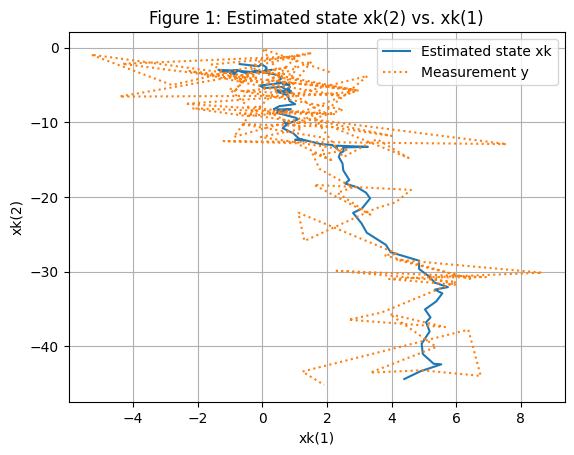

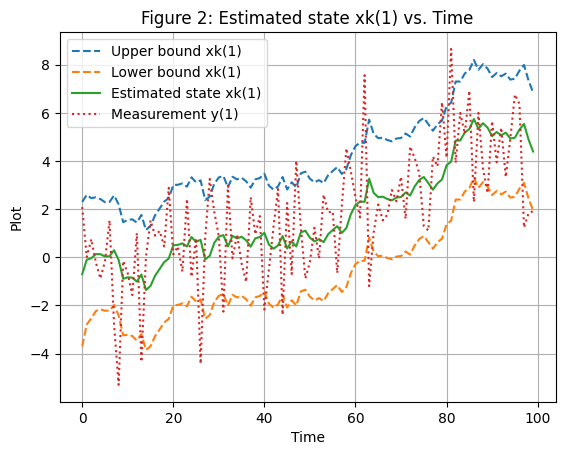

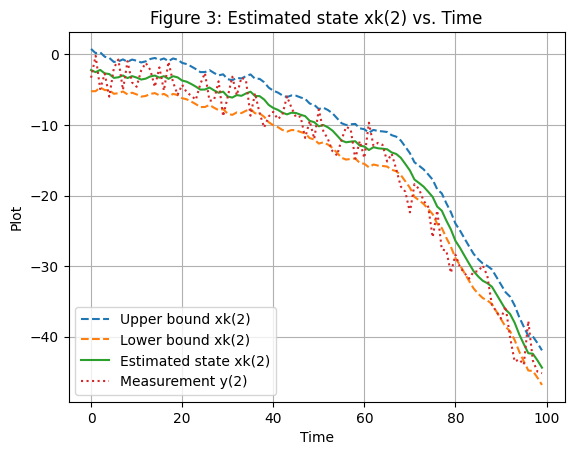

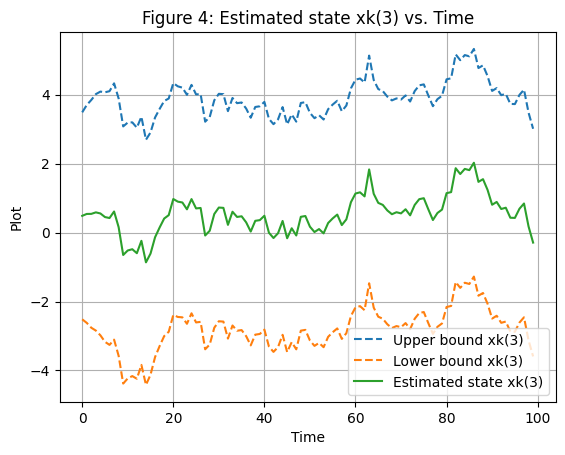

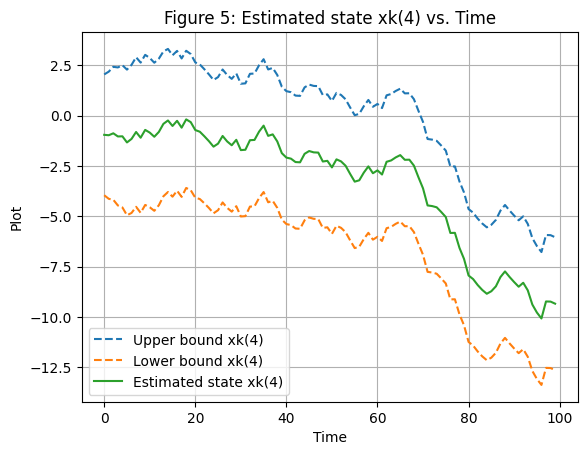

In [306]:
# plot
plt.plot(x_k_k[:, 0], x_k_k[:, 1], label="Estimated state xk")
plt.plot(y[:, 0], y[:, 1], ":", label="Measurement y")
plt.xlabel("xk(1)")
plt.ylabel("xk(2)")
plt.title("Figure 1: Estimated state xk(2) vs. xk(1)")
plt.grid(True)
plt.legend()
plt.show()

t = np.arange(N)

for k in range(4):
    p = P_k_k[:, k, k]
    plot1 = x_k_k[:, k] + 3 * np.sqrt(p)
    plot2 = x_k_k[:, k] - 3 * np.sqrt(p)
    plt.plot(t, plot1, "--", label=f"Upper bound xk({k + 1})")
    plt.plot(t, plot2, "--", label=f"Lower bound xk({k + 1})")
    plt.plot(t, x_k_k[:, k], label=f"Estimated state xk({k + 1})")
    if k < 2:
        plt.plot(t, y[:, k], ":", label=f"Measurement y({k+1})")
    plt.xlabel("Time")
    plt.ylabel("Plot")
    plt.title(f"Figure {k + 2}: Estimated state xk({k + 1}) vs. Time")
    plt.grid(True)
    plt.legend()
    plt.show()

## Problem 4: Smooth Kalman Filter

The graphs below show the uncertainty boundaries of the Rauch-Tung-Striebel smoothing. Similar with Problem 3, it shows the confidence interval of the smoother with 99.7% range of the possible values if the error follows normal Gaussian distribution. This smoother enhances the estimation provided by the Kalman filter by incorporating future measurements into the estimation process. 

From the plot, it is shown that  the smoothed estimate closely aligns with the measurements and shows minimal divergence from the estimated state provided by the Kalman filter, it indicates that the RTS smoother effectively optimizes the estimation by leveraging future information k+1. This suggests a refined and more accurate representation of the true system state.

In [307]:
def smooth_kalman(A, Q, x_k_k, P_k_k, xs_next_next, Ps_next_next):
    # prediction
    x_next_k = A @ x_k_k
    P_next_k = A @ P_k_k @ A.T + Q

    # correction
    G_k = P_k_k @ A.T @ np.linalg.inv(P_next_k)
    xs_k_k = x_k_k + G_k @ (xs_next_next - x_next_k)
    Ps_k_k = P_k_k + G_k @ (Ps_next_next - P_next_k) @ G_k.T
    
    return G_k, xs_k_k, Ps_k_k

x_next_k = np.zeros((N, 4))
P_next_k = np.zeros((N, 4, 4))
G_k = np.zeros((N, 4, 4))

xs_k_k = np.zeros((N, 4))
Ps_k_k = np.zeros((N, 4, 4))

xs_k_k[N - 1] = x_k_k[N - 1]
Ps_k_k[N - 1] = P_k_k[N - 1]

for k in range(N - 2, -1, -1):
    G_k[k], xs_k_k[k], Ps_k_k[k] = smooth_kalman(A, Q,
                                                 x_k_k[k], P_k_k[k],
                                                 xs_k_k[k + 1], Ps_k_k[k + 1])

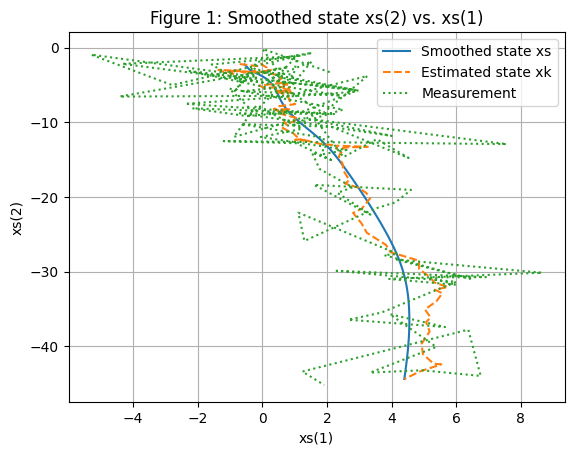

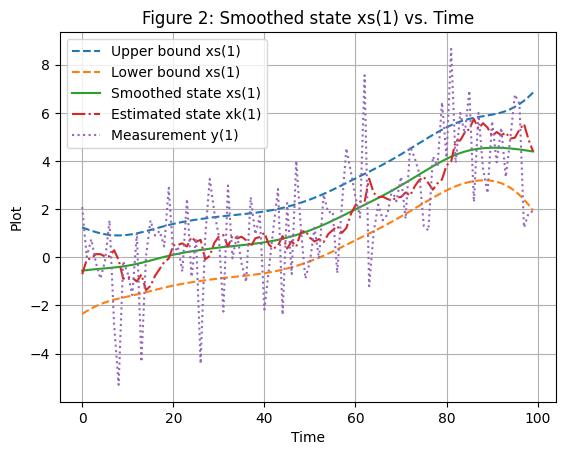

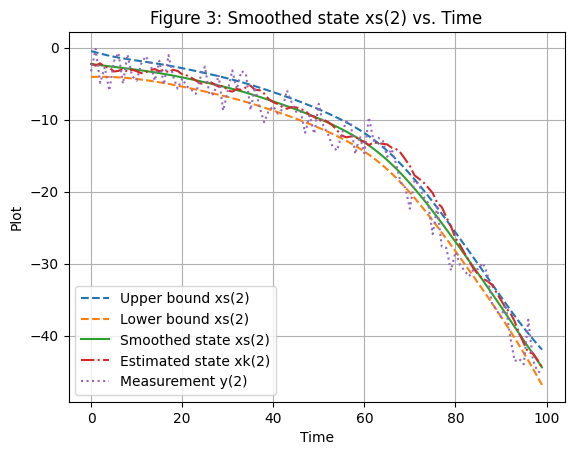

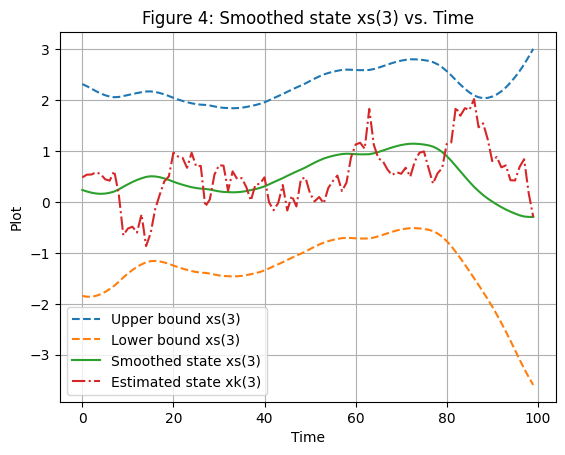

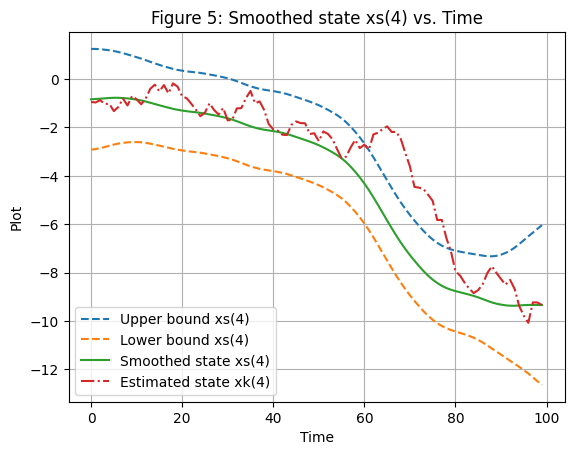

In [310]:
# plot
plt.plot(xs_k_k[:, 0], xs_k_k[:, 1], label="Smoothed state xs")
plt.plot(x_k_k[:, 0], x_k_k[:, 1], "--", label="Estimated state xk")
plt.plot(y[:, 0], y[:, 1], ":", label="Measurement")
plt.xlabel("xs(1)")
plt.ylabel("xs(2)")
plt.title("Figure 1: Smoothed state xs(2) vs. xs(1)")
plt.grid(True)
plt.legend()
plt.show()

for k in range(4):
    ps = Ps_k_k[:, k, k]
    plot1 = xs_k_k[:, k] + 3 * np.sqrt(ps)
    plot2 = xs_k_k[:, k] - 3 * np.sqrt(ps)
    plt.plot(t, plot1, "--", label=f"Upper bound xs({k + 1})")
    plt.plot(t, plot2, "--", label=f"Lower bound xs({k + 1})")
    
    p = P_k_k[:, k, k]
    plot3 = x_k_k[:, k] + 3 * np.sqrt(p)
    plot4 = x_k_k[:, k] - 3 * np.sqrt(p)
    
    plt.plot(t, xs_k_k[:, k], label=f"Smoothed state xs({k + 1})")
    plt.plot(t, x_k_k[:, k], "-.", label=f"Estimated state xk({k + 1})")
    if k < 2:
        plt.plot(t, y[:, k], ":", label=f"Measurement y({k+1})")

    plt.xlabel("Time")
    plt.ylabel("Plot")
    plt.title(f"Figure {k + 2}: Smoothed state xs({k + 1}) vs. Time")
    plt.grid(True)
    plt.legend()
    plt.show()
    